<Axes: title={'center': '7b p90 per request latency'}, xlabel='num_different_long_prefix,percent_random_prefixes,num_requests,rps'>

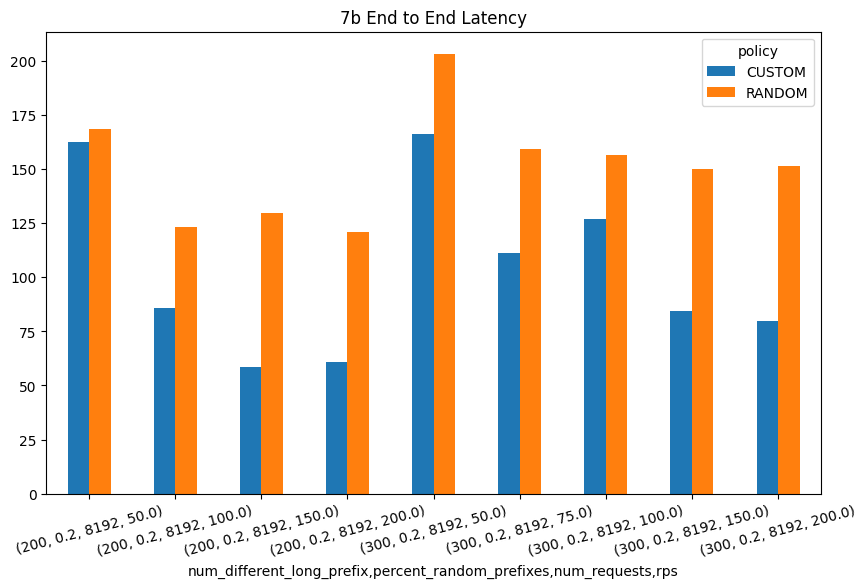

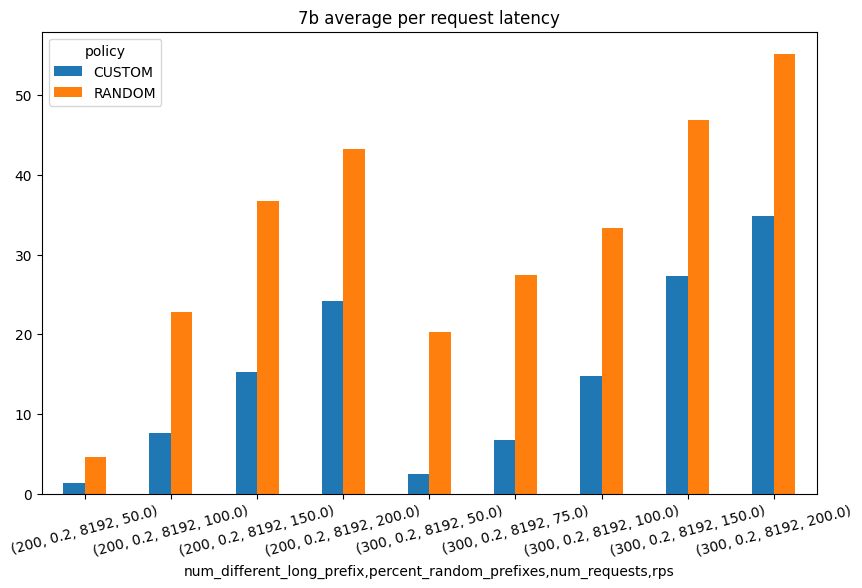

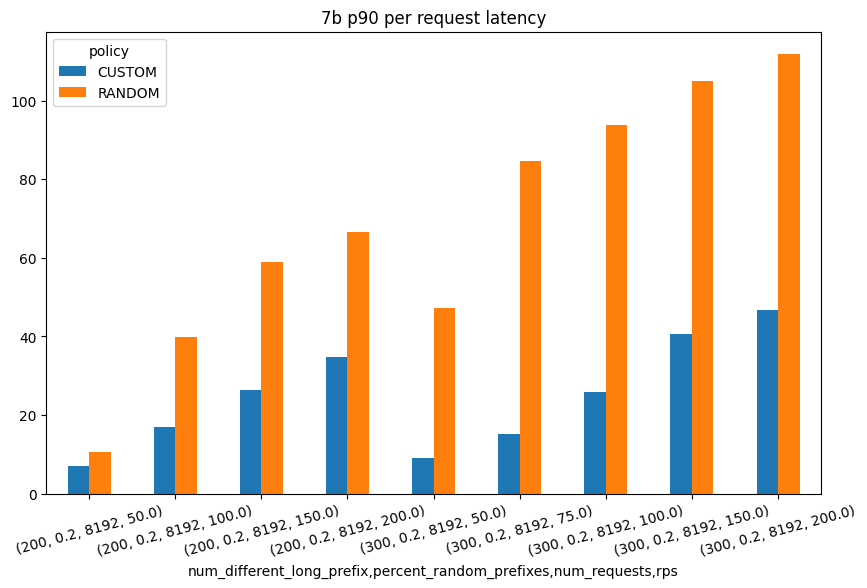

In [2]:
import re
import matplotlib.pyplot as plt
import pandas as pd

def extract_policy_and_number(log_file):
    overall_latencies = []
    request_latencies = []
    with open(log_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            # Extract lines containing overall latency
            if 'Overall Latency' in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Overall Latency: (.*)', line)
                if match:
                    # if int(match.group(2)) == 300:
                    #     continue
                    overall_latencies.append({
                        "model_name": match.group(1),
                        "num_different_long_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "rps": float(match.group(5)),
                        "policy": match.group(6),
                        "latency": float(match.group(7))
                    })
            elif "Overall Request Latency:" in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Overall Request Latency: (.*), STD: (.*), P90: (.*)', line)
                if match:
                    # if int(match.group(2)) == 300:
                    #     continue
                    request_latencies.append({
                        "model_name": match.group(1),
                        "num_different_long_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "rps": float(match.group(5)),
                        "policy": match.group(6),
                        "avg_latency": float(match.group(7)),
                        "std": float(match.group(8)),
                        "p90": float(match.group(9))
                    })                

    return overall_latencies, request_latencies

log_file = '/mnt/ssd1/alm-os/sglang_multi_model/7b_rps_test.log'
result, request_latencies = extract_policy_and_number(log_file)

df = pd.DataFrame(result)
# df = df.drop("num_requests", axis=1)
df = df.drop("model_name", axis=1)
df = df.groupby(['num_different_long_prefix', 'percent_random_prefixes', 'num_requests', 'rps', 'policy'])['latency'].mean().unstack()
df.plot(kind='bar', figsize=(10, 6), title="7b End to End Latency", rot=15)

request_latency_df = pd.DataFrame(request_latencies)
request_latency_df = request_latency_df.drop("model_name", axis=1)
request_latency_df = request_latency_df.groupby(['num_different_long_prefix', 'percent_random_prefixes', 'num_requests', 'rps', 'policy'])["avg_latency"].mean().unstack()
request_latency_df.plot(kind='bar', figsize=(10, 6), title="7b average per request latency", rot=15)

request_latency_df = pd.DataFrame(request_latencies)
request_latency_df = request_latency_df.drop("model_name", axis=1)
request_latency_df = request_latency_df.groupby(['num_different_long_prefix', 'percent_random_prefixes', 'num_requests', 'rps', 'policy'])["p90"].mean().unstack()
request_latency_df.plot(kind='bar', figsize=(10, 6), title="7b p90 per request latency", rot=15)


# df["Speedup"] = df["RANDOM"] / df["CUSTOM"]
# df = df.reset_index()
# labels = df.apply(lambda x: f'({x["num_different_long_prefix"]}, {x["percent_random_prefixes"]})', axis=1)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.bar(labels, df['Speedup'])
# plt.title('Speedup of End to End Latency of 7b')
# plt.xlabel('(num_different_long_prefix, percent_random_prefixes, num_requests)')
# plt.ylabel('Speedup')
# ax.axhline(y=1.0, color='r', linestyle='--')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()
